In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

adata_counts = sc.read_csv("E:/Mouse_V1/P28NR/GSE190940_P28NR.csv")

sample_IDs = ["E:/Mouse_V1/Projection_Seq_CC_Glut", "E:/Mouse_V1/P28NR/P28_glut"]

accum_adata, cell_count = [], 0
for sample in sample_IDs:
    pre_path = sample + ".h5ad"
    temp_adata = sc.read_h5ad(
        pre_path,
                              )
    temp_adata.var_names_make_unique()
    
    if "P28" in sample:
        obs_names = [name[:29] for name in temp_adata.obs_names]
        X_counts = adata_counts[obs_names, temp_adata.var_names].X
        temp_adata.X = X_counts
    
    accum_adata.append(temp_adata)
    cell_count += temp_adata.n_obs

adata = accum_adata[0].concatenate(*accum_adata[1:], batch_categories=sample_IDs)
adata

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 20557 × 19204
    obs: 'doublet', 'doublet_score', 'UPB1', 'UPB2', 'Bino', 'Mono', 'UPBs', 'VISs', 'n_genes', 'percent_mito', 'n_UMIs', 'n_counts', 'leiden', 'class', 'batch', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'
    var: 'feature_types', 'gene_ids-E:/Mouse_V1/P28NR/P28_glut', 'n_cells-E:/Mouse_V1/P28NR/P28_glut', 'highly_variable-E:/Mouse_V1/P28NR/P28_glut', 'means-E:/Mouse_V1/P28NR/P28_glut', 'dispersions-E:/Mouse_V1/P28NR/P28_glut', 'dispersions_norm-E:/Mouse_V1/P28NR/P28_glut', 'mean-E:/Mouse_V1/P28NR/P28_glut', 'std-E:/Mouse_V1/P28NR/P28_glut', 'gene_ids-E:/Mouse_V1/Projection_Seq_CC_Glut', 'genome-E:/Mouse_V1/Projection_Seq_CC_Glut'

In [2]:
dataset = []
for batch in adata.obs["batch"]:
    if "P28" in batch:
        dataset.append("Cell Paper")
    else:
        dataset.append("Projection-seq")
adata.obs["dataset"] = dataset

In [3]:
mask = np.array(np.isnan(adata.obs["UPB1"]))

for upb in ["UPB1", "UPB2"]:
    adata.obs.loc[mask, upb] = 0.0

C:\Users\TLab\AppData\Local\Temp\ipykernel_3860\1235271624.py:14: UserWarning: The label '_' of <matplotlib.collections.LineCollection object at 0x00000134140F3130> starts with '_'. It is thus excluded from the legend.
  ax.legend(["_"] + upbs, loc="upper right")


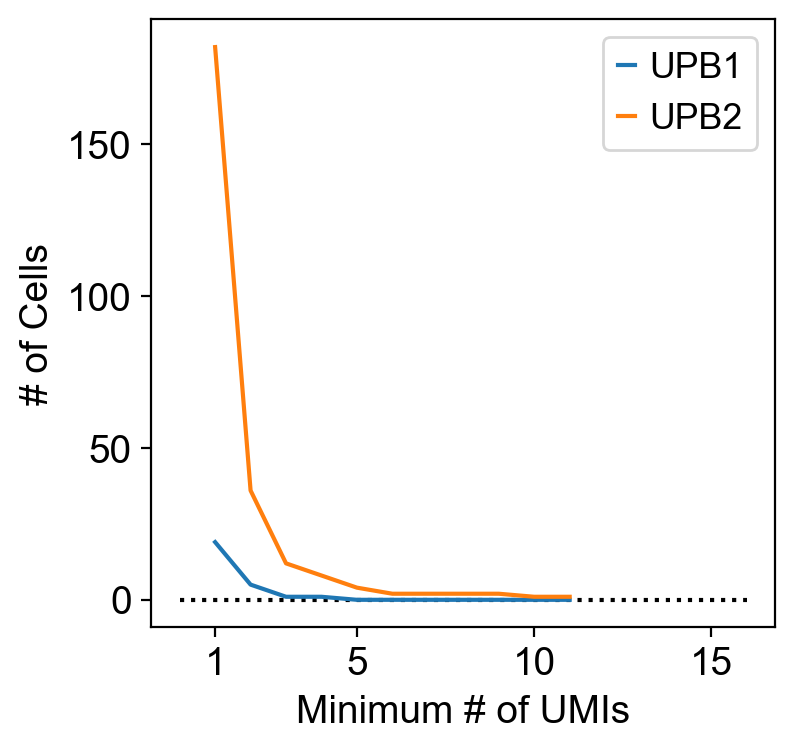

In [4]:
upbs = ["UPB1", "UPB2"]
max_count = np.max(adata.obs[upbs]).astype(int)
counts = np.zeros((max_count, len(upbs)))
for idx, count in enumerate(counts):
    ct = np.sum(adata.obs[upbs] > idx, axis=0)
    counts[idx, :] = ct

fig, ax = plt.subplots()
ax.hlines(0, 0, 16, colors="k", linestyles="dotted")
ax.plot(np.arange(max_count) + 1, counts)
ax.set_xlabel("Minimum # of UMIs")
ax.set_xticks((1, 5, 10, 15))
ax.set_ylabel("# of Cells")
ax.legend(["_"] + upbs, loc="upper right")
ax.grid(False)
plt.show(block=False)

C:\Users\TLab\AppData\Local\Temp\ipykernel_3860\1742320562.py:18: UserWarning: The label '_' of <matplotlib.collections.LineCollection object at 0x00000134ADC67D60> starts with '_'. It is thus excluded from the legend.
  ax.legend(["_", "Bino", "Mono", "Bino & Mono"], loc="upper right")


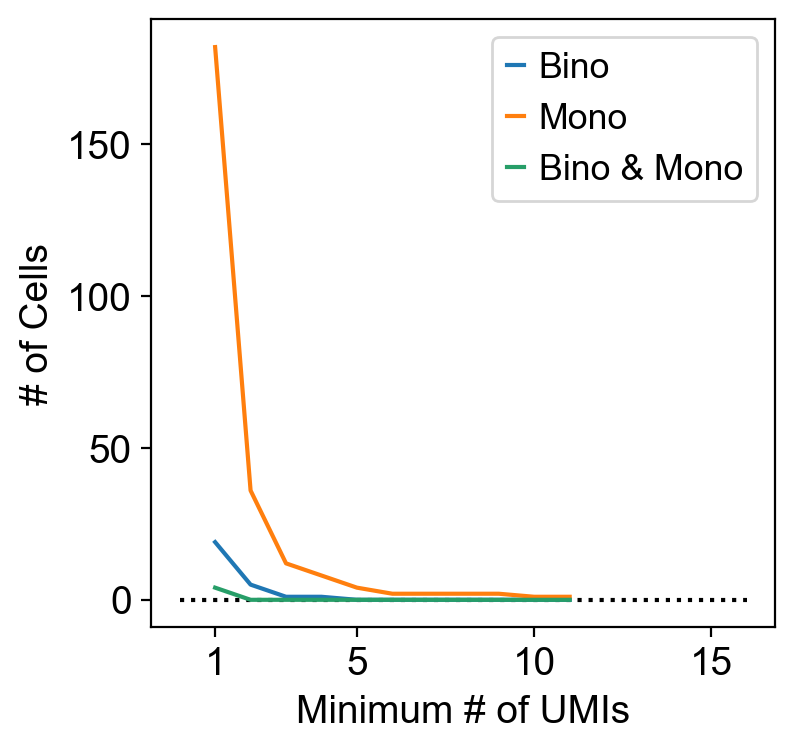

In [5]:
upbs = ["UPB1", "UPB2"]
max_count = np.max(adata.obs[upbs]).astype(int)
counts = np.zeros((max_count, 3))
for idx, count in enumerate(counts):
    BINO = np.sum(adata.obs[["UPB1"]] > idx, axis=1) > 0
    MONO = np.sum(adata.obs[["UPB2"]] > idx, axis=1) > 0
    BOTH = np.logical_and(BINO, MONO)
    ct = np.sum(np.vstack((BINO, MONO, BOTH)).T, axis=0)
    counts[idx, :] = ct


fig, ax = plt.subplots()
ax.hlines(0, 0, 16, colors="k", linestyles="dotted")
ax.plot(np.arange(max_count) + 1, counts)
ax.set_xlabel("Minimum # of UMIs")
ax.set_xticks((1, 5, 10, 15))
ax.set_ylabel("# of Cells")
ax.legend(["_", "Bino", "Mono", "Bino & Mono"], loc="upper right")
ax.grid(False)
plt.show(block=False)

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


2023-08-14 13:46:31,152 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-14 13:46:37,405 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-14 13:46:37,587 - harmonypy - INFO - Iteration 1 of 20
2023-08-14 13:46:45,495 - harmonypy - INFO - Iteration 2 of 20
2023-08-14 13:46:53,866 - harmonypy - INFO - Iteration 3 of 20
2023-08-14 13:47:01,434 - harmonypy - INFO - Iteration 4 of 20
2023-08-14 13:47:08,494 - harmonypy - INFO - Iteration 5 of 20
2023-08-14 13:47:12,135 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


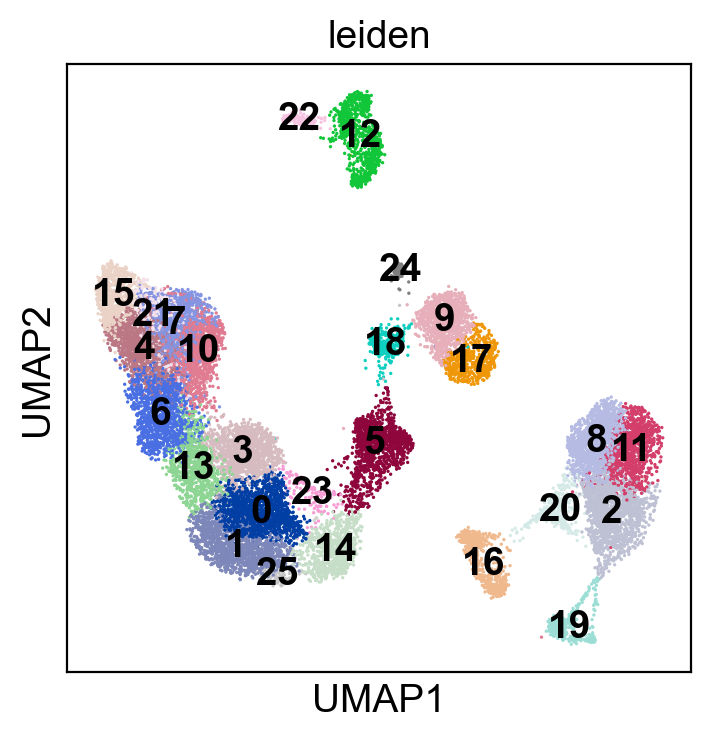

In [16]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "dataset", theta=4, max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata, key_added="leiden", resolution=2)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


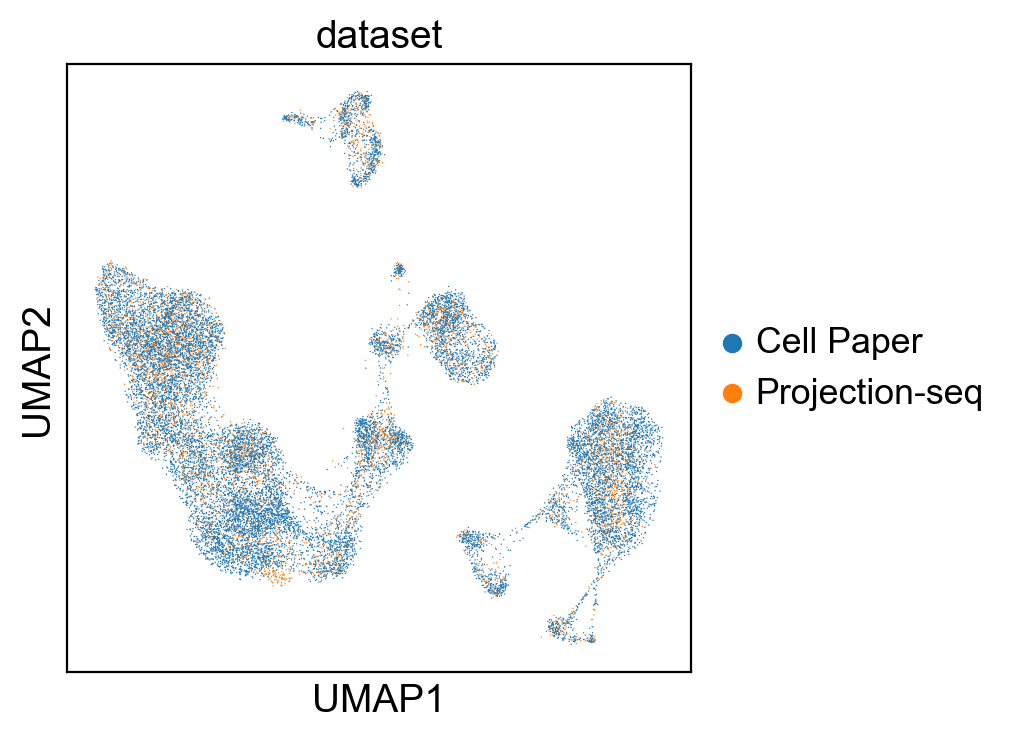

In [17]:
sc.pl.umap(adata, color=["dataset"], alpha=1, size=1)

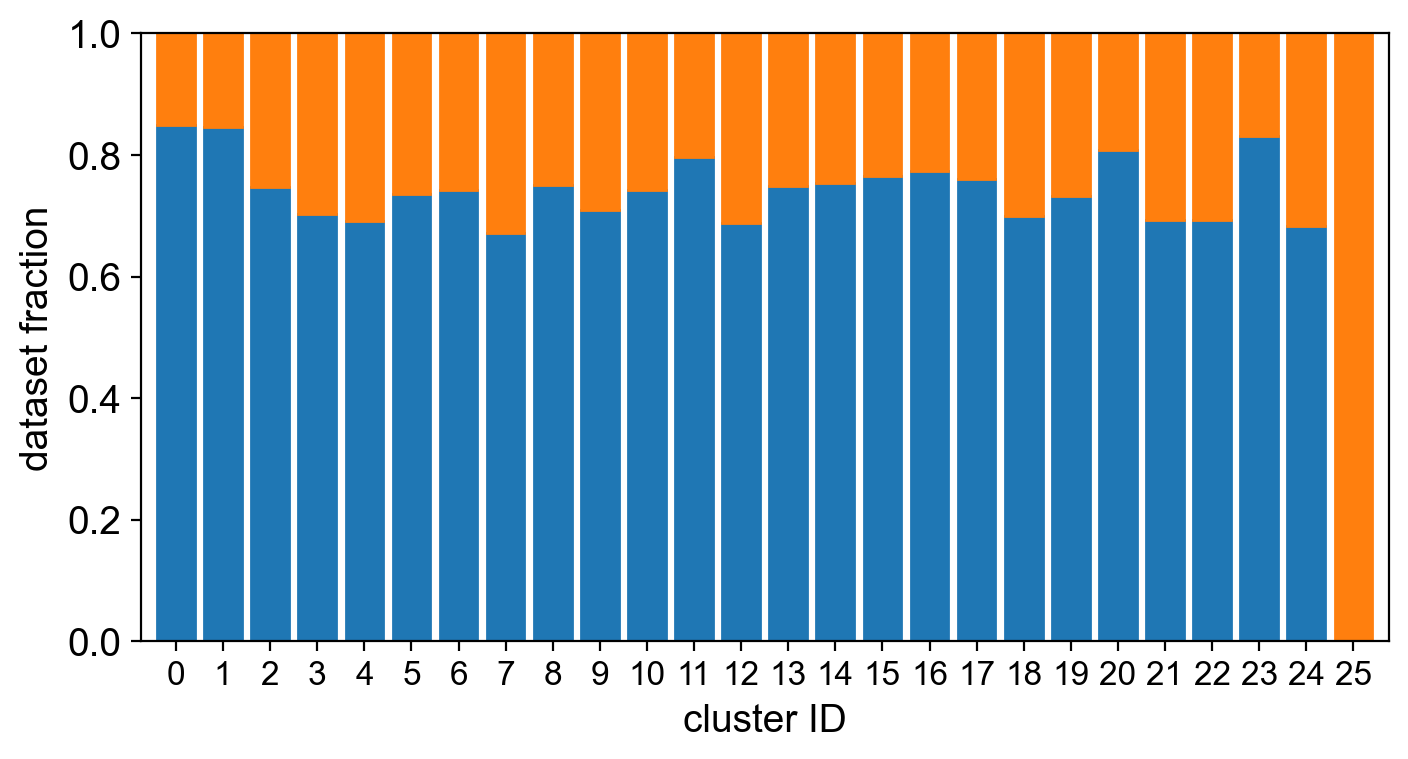

In [18]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in ["Cell Paper", "Projection-seq"]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["dataset"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["dataset_colors"]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("dataset fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


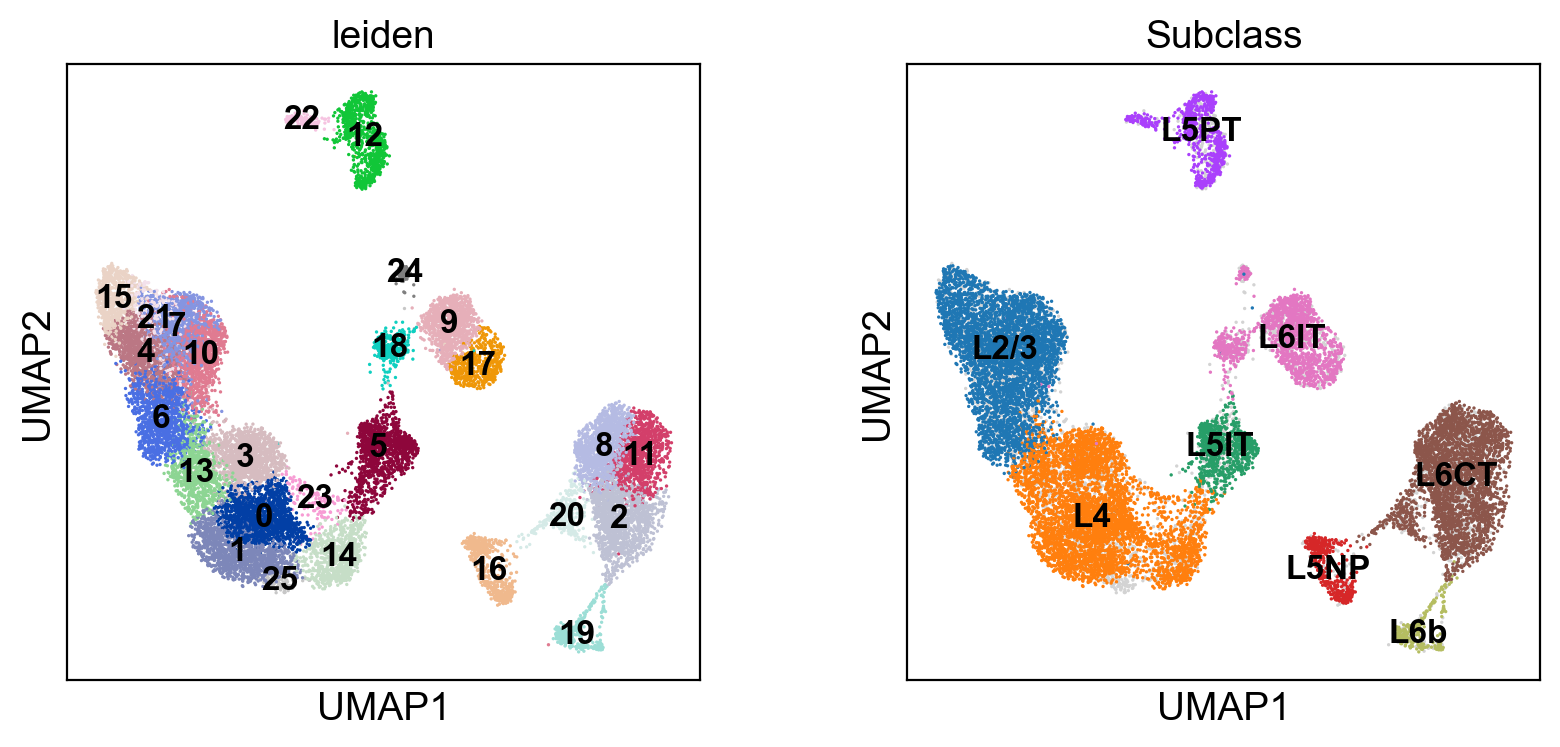

In [19]:
sc.pl.umap(adata, color=["leiden", "Subclass"], legend_loc="on data", na_in_legend=False, legend_fontsize=12)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


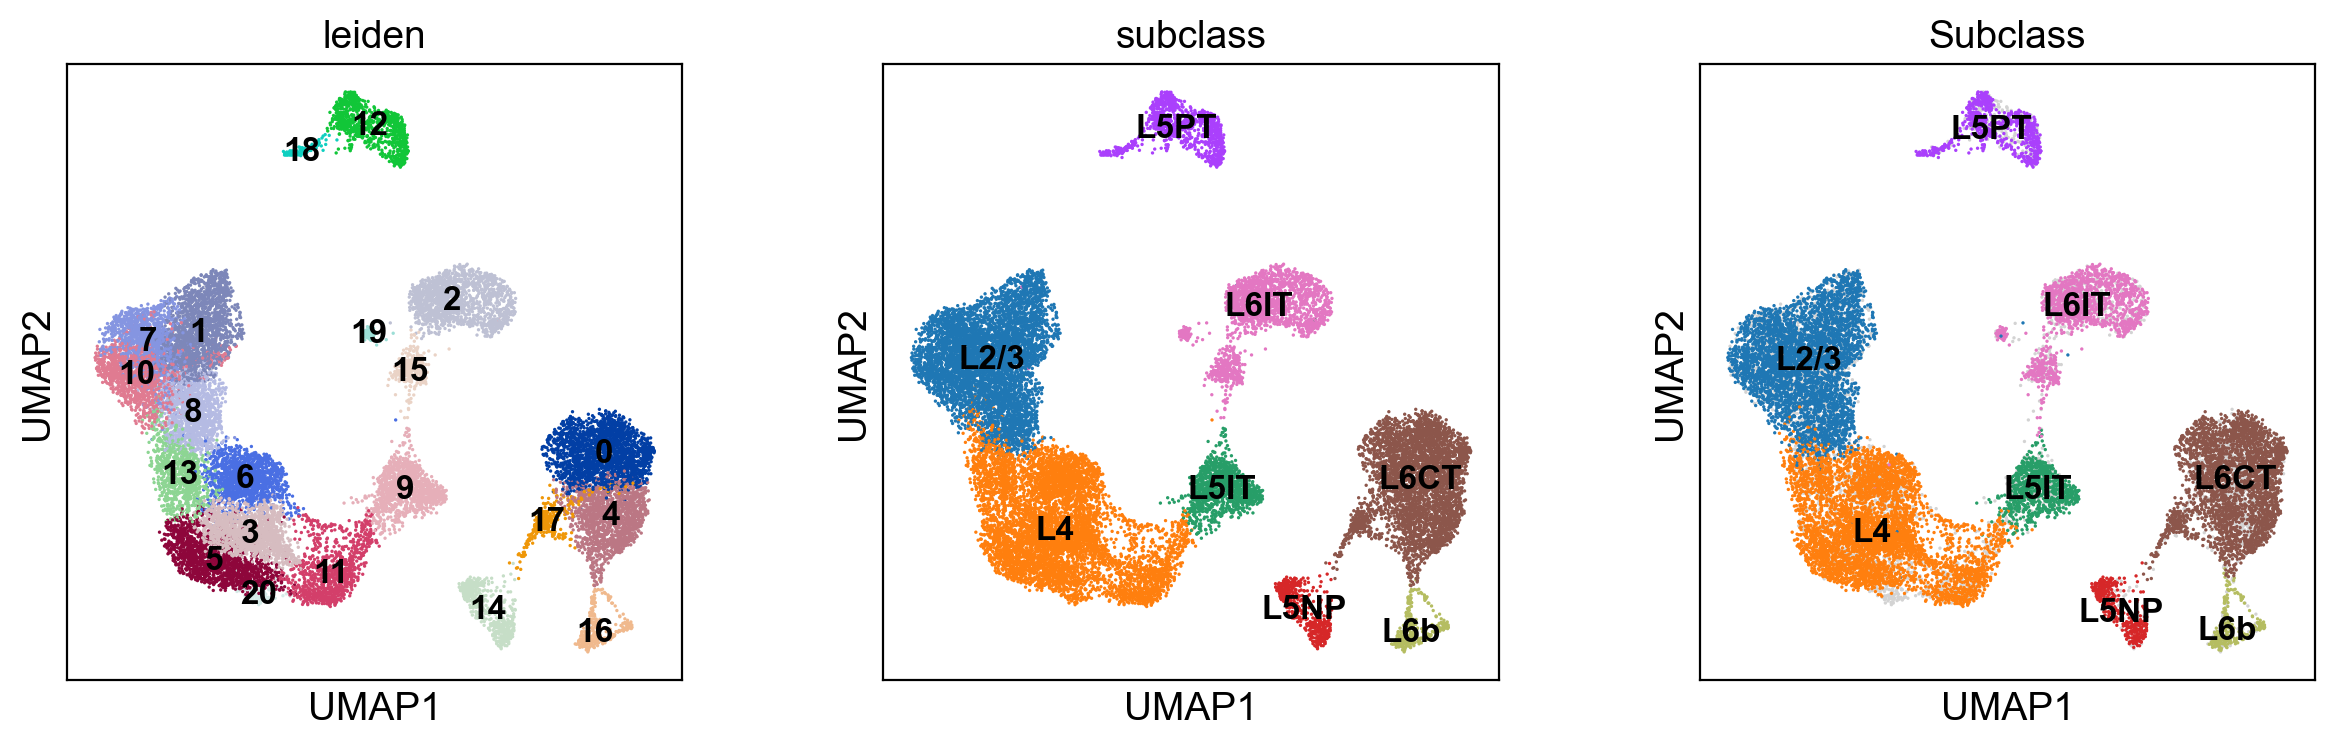

In [13]:
subclass_idx = {
            "L2/3" : ["1", "7", "8", "10"], 
            "L4" : ["3", "5", "6", "11", "13", "20"], 
            "L5IT" : ["9"], 
            "L5NP" : ["14"], 
            "L5PT" : ["12", "18"], 
            "L6IT" : ["2", "15", "19"], 
            "L6CT" : ["0", "4", "17"], 
            "L6b" : ["16"], 
               }

adata.obs["subclass"] = [None] * adata.shape[0]

for name, idx in subclass_idx.items():
    mask = np.isin(adata.obs["leiden"], idx)
    adata.obs.loc[mask, "subclass"] = [name] * np.sum(mask)

sc.pl.umap(adata, color=["leiden", "subclass", "Subclass"], legend_loc="on data", na_in_legend=False, legend_fontsize=12)

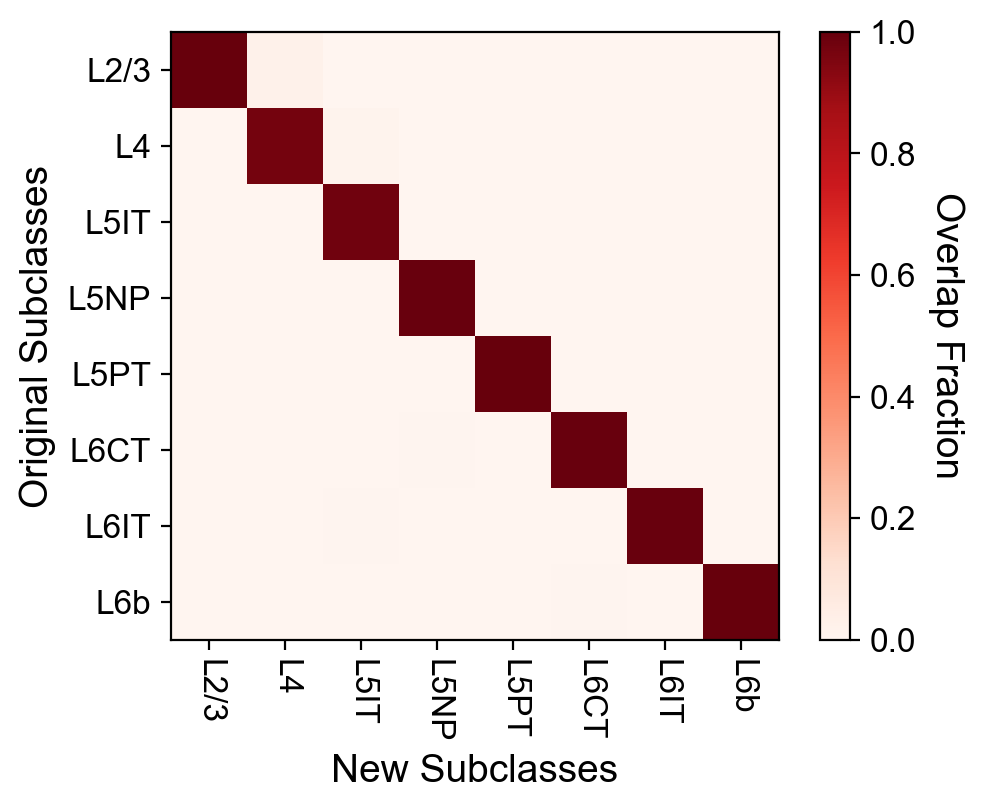

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter

adata_orig = adata[adata.obs["dataset"] == "Cell Paper", :]

type_IDs = np.unique(adata_orig.obs["subclass"])
type_map = np.zeros((len(type_IDs), adata_orig.shape[0], 2))
for idx_ver, ver in enumerate(["Subclass", "subclass"]):
    for idx_typ, typ in enumerate(type_IDs):
        type_map[idx_typ, :, idx_ver] = adata_orig.obs[ver] == typ
cross_map = np.matmul(type_map[:, :, 0], type_map[:, :, 1].T) / np.sum(type_map[:, :, 1], axis=1)

fig, ax = plt.subplots()
ax.matshow(cross_map, cmap="Reds")
ax.set_xticks(np.arange(len(type_IDs)))
ax.set_xticklabels(type_IDs, fontsize=12, rotation=-90)
ax.set_xlabel("New Subclasses")
ax.set_yticks(np.arange(len(type_IDs)))
ax.set_yticklabels(type_IDs, fontsize=12)
ax.set_ylabel("Original Subclasses")
ax.xaxis.set_ticks_position('bottom')
cax = inset_axes(ax, width="5%", height="100%", loc="center right", borderpad=-2)
colorbar = fig.colorbar(ax.images[0], cax=cax)
colorbar.set_label("Overlap Fraction\n", color="k", fontsize=14, rotation=-90)
cax.yaxis.tick_right()
cax.yaxis.set_label_position("right")
cax.yaxis.set_label_coords(4.75, 0.5)
cax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
cax.tick_params(labelsize=12)
cax.grid(False)
ax.grid(False)
plt.show(block=False)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


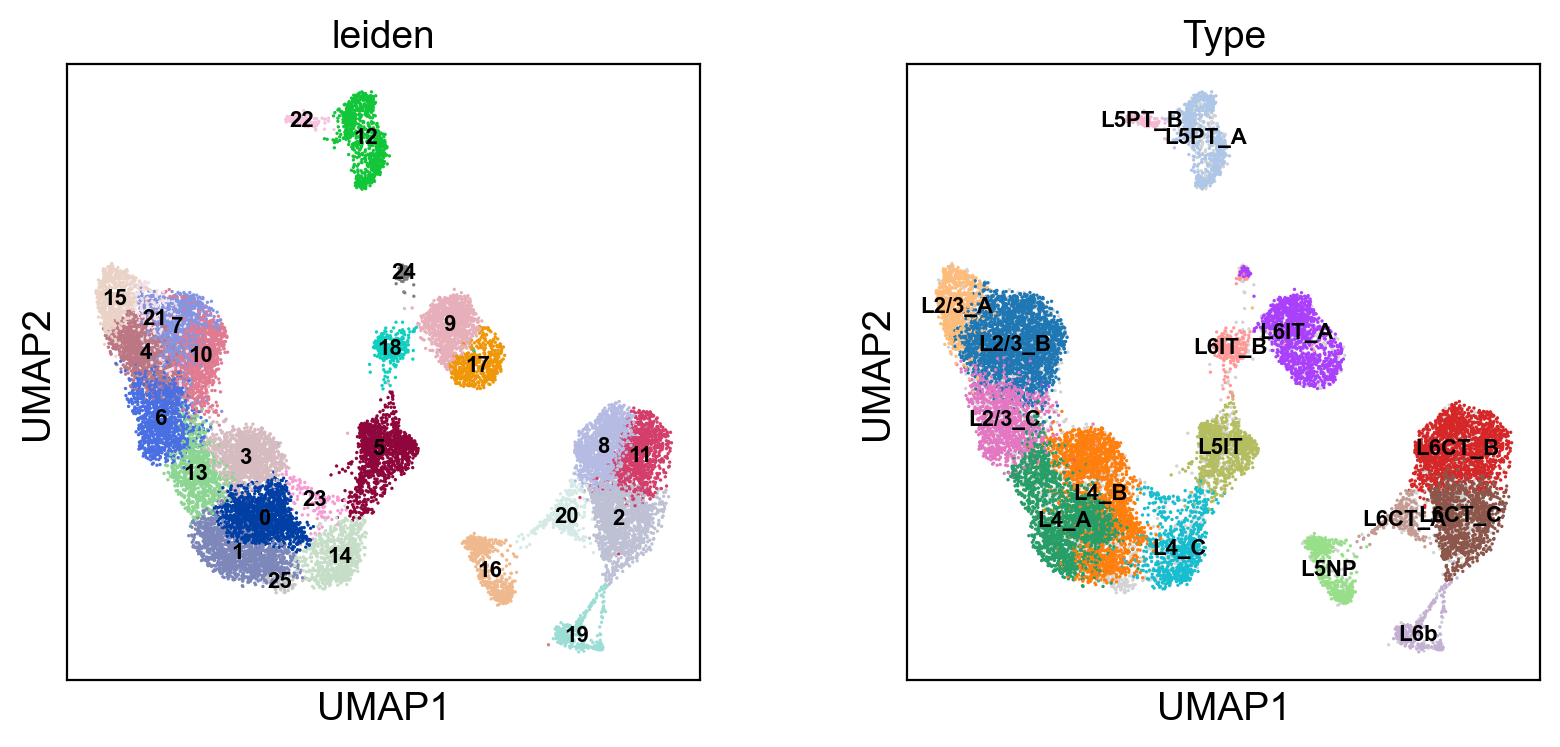

In [20]:
sc.pl.umap(adata, color=["leiden", "Type"], legend_loc="on data", na_in_legend=False, legend_fontsize=8)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


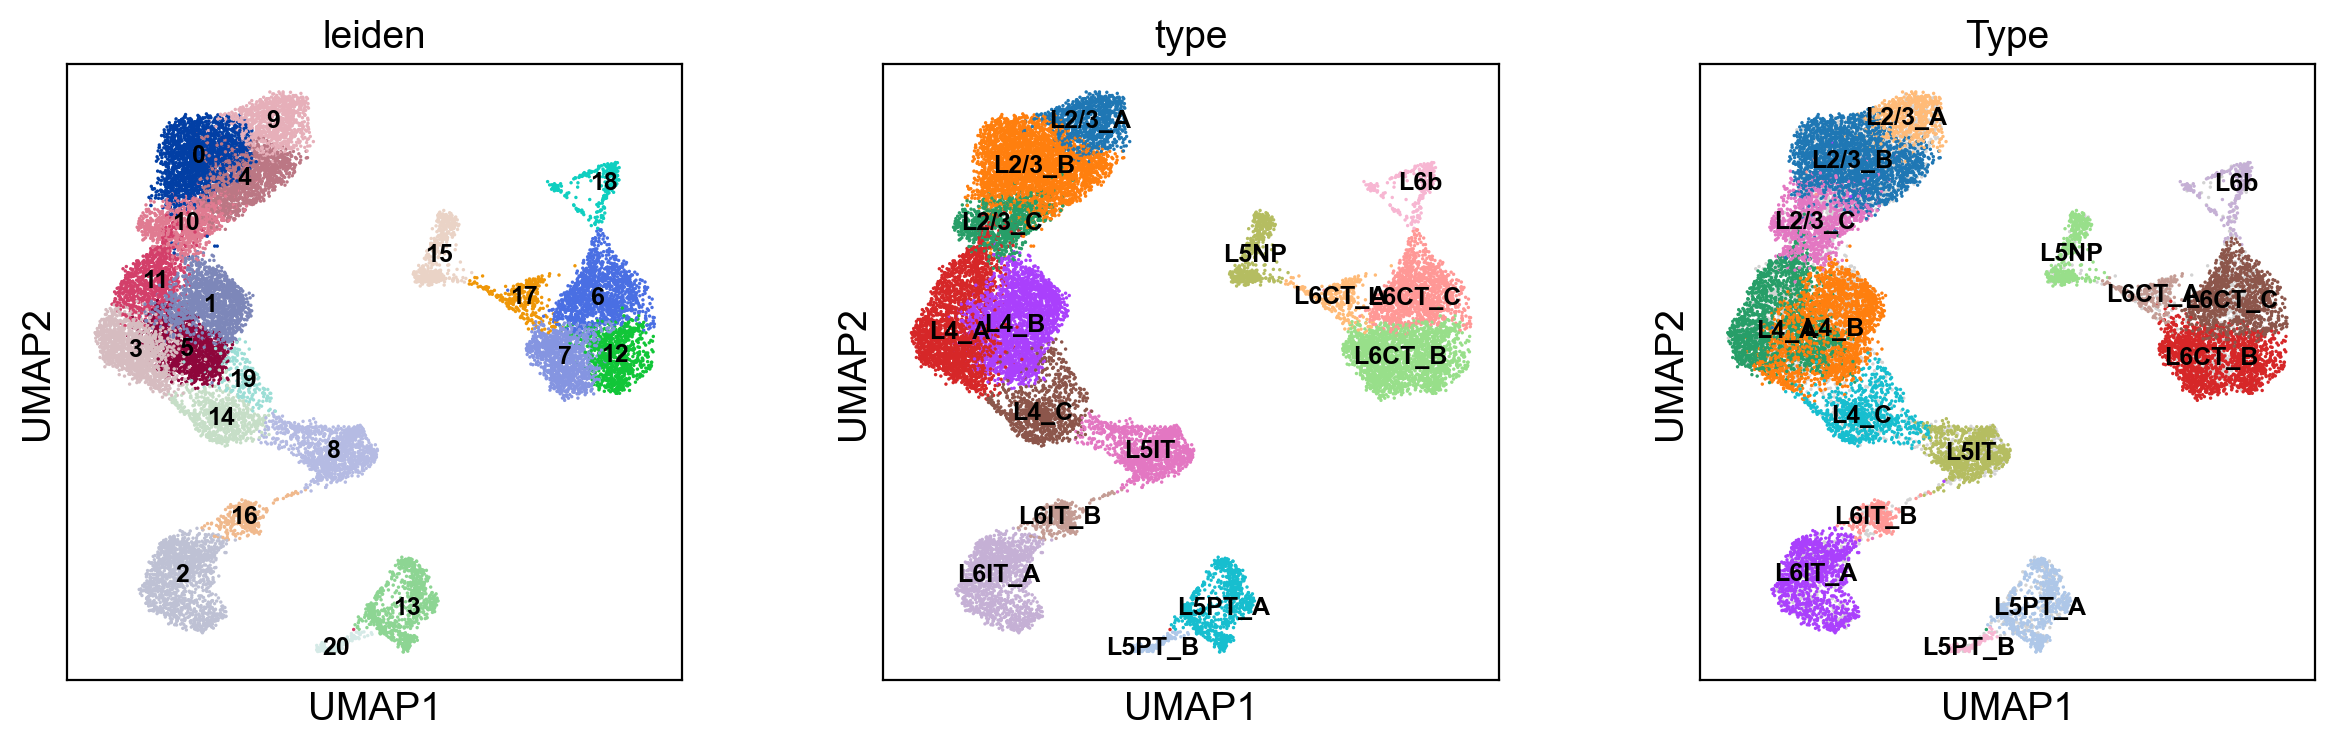

In [42]:
type_idx = {
        "L2/3_A" : ["9"], 
        "L2/3_B" : ["0", "4"], 
        "L2/3_C" : ["10"], 
        "L4_A" : ["3", "11"], 
        "L4_B" : ["1", "5"], 
        "L4_C" : ["14", "19"], 
        "L5IT" : ["8"], 
        "L5NP" : ["15"], 
        "L5PT_A" : ["13"], 
        "L5PT_B" : ["20"], 
        "L6IT_A" : ["2"], 
        "L6IT_B" : ["16"], 
        "L6CT_A" : ["17"], 
        "L6CT_B" : ["7", "12"], 
        "L6CT_C" : ["6"], 
        "L6b" : ["18"], 
            }

adata.obs["type"] = [None] * adata.shape[0]

for name, idx in type_idx.items():
    mask = np.isin(adata.obs["leiden"], idx)
    adata.obs.loc[mask, "type"] = [name] * np.sum(mask)

sc.pl.umap(adata, color=["leiden", "type", "Type"], legend_loc="on data", na_in_legend=False, legend_fontsize=9)

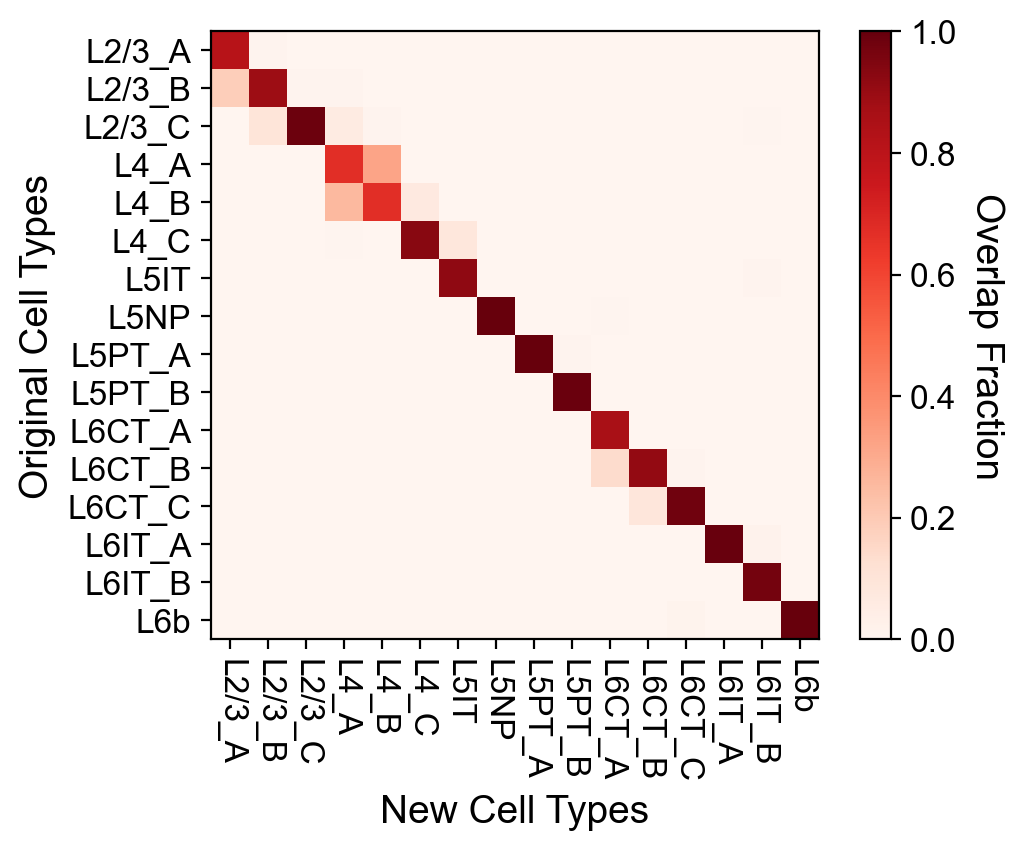

In [46]:
adata_orig = adata[adata.obs["dataset"] == "Cell Paper", :]

type_IDs = np.unique(adata_orig.obs["type"].astype(str))
type_map = np.zeros((len(type_IDs), adata_orig.shape[0], 2))
for idx_ver, ver in enumerate(["Type", "type"]):
    for idx_typ, typ in enumerate(type_IDs):
        type_map[idx_typ, :, idx_ver] = adata_orig.obs[ver] == typ
cross_map = np.matmul(type_map[:, :, 0], type_map[:, :, 1].T) / np.sum(type_map[:, :, 1], axis=1)

fig, ax = plt.subplots()
ax.matshow(cross_map, cmap="Reds")
ax.set_xticks(np.arange(len(type_IDs)))
ax.set_xticklabels(type_IDs, fontsize=12, rotation=-90)
ax.set_xlabel("New Cell Types")
ax.set_yticks(np.arange(len(type_IDs)))
ax.set_yticklabels(type_IDs, fontsize=12)
ax.set_ylabel("Original Cell Types")
ax.xaxis.set_ticks_position('bottom')
cax = inset_axes(ax, width="5%", height="100%", loc="center right", borderpad=-2)
colorbar = fig.colorbar(ax.images[0], cax=cax)
colorbar.set_label("Overlap Fraction", color="k", fontsize=14, rotation=-90)
cax.yaxis.tick_right()
cax.yaxis.set_label_position("right")
cax.yaxis.set_label_coords(4.75, 0.5)
cax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
cax.tick_params(labelsize=12)
cax.grid(False)
ax.grid(False)
plt.show(block=False)

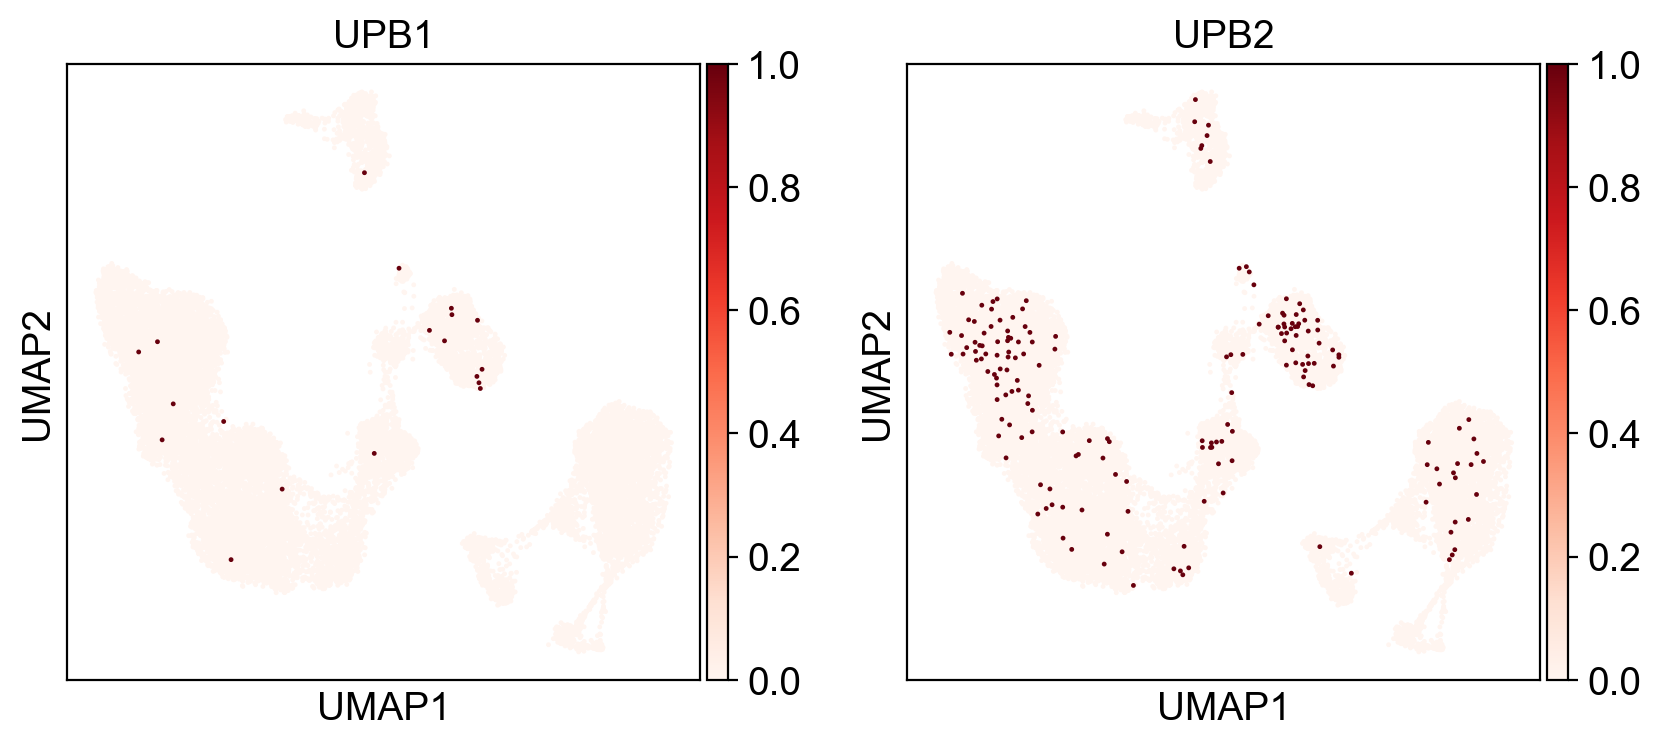

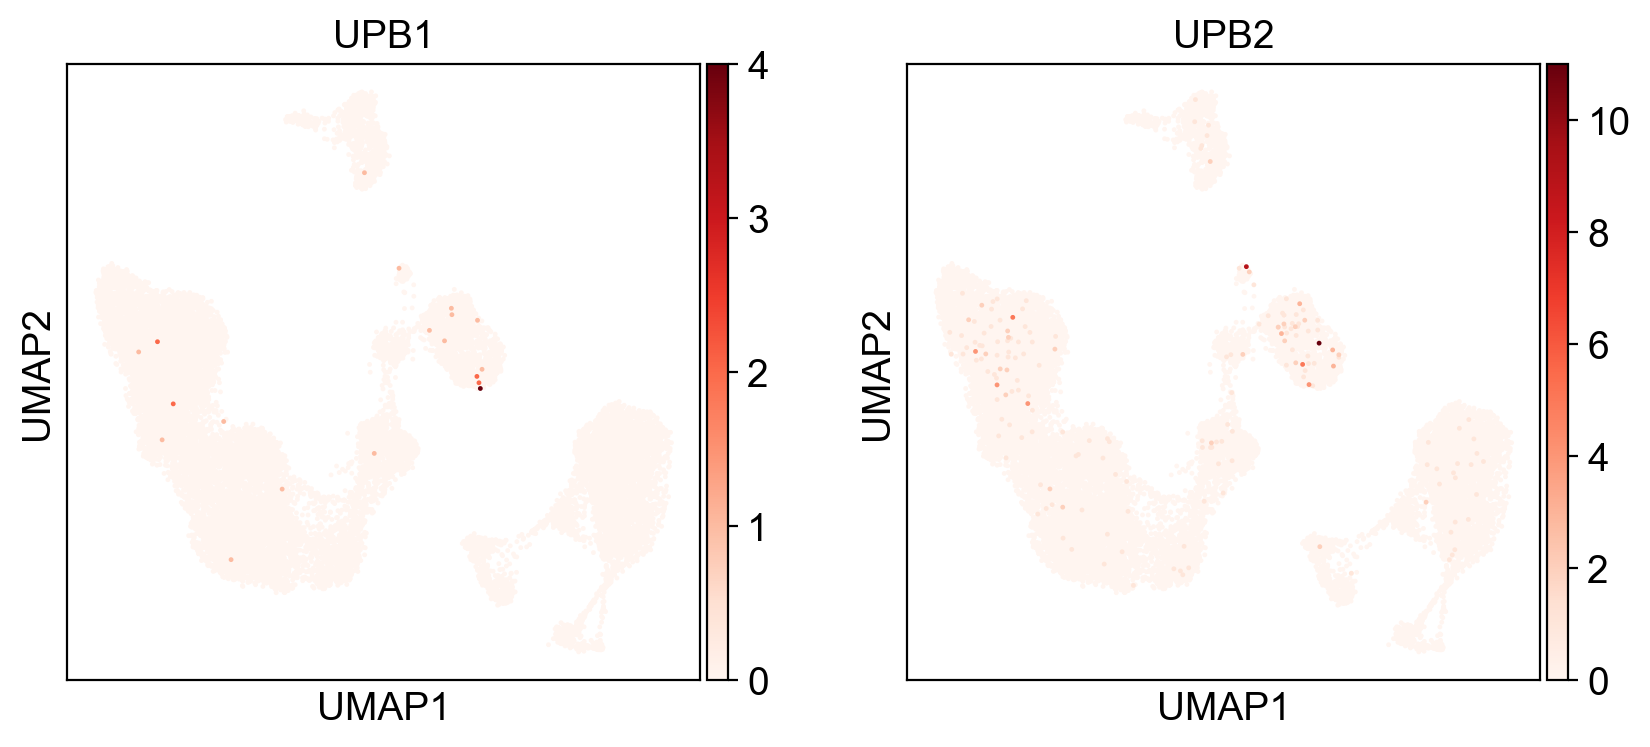

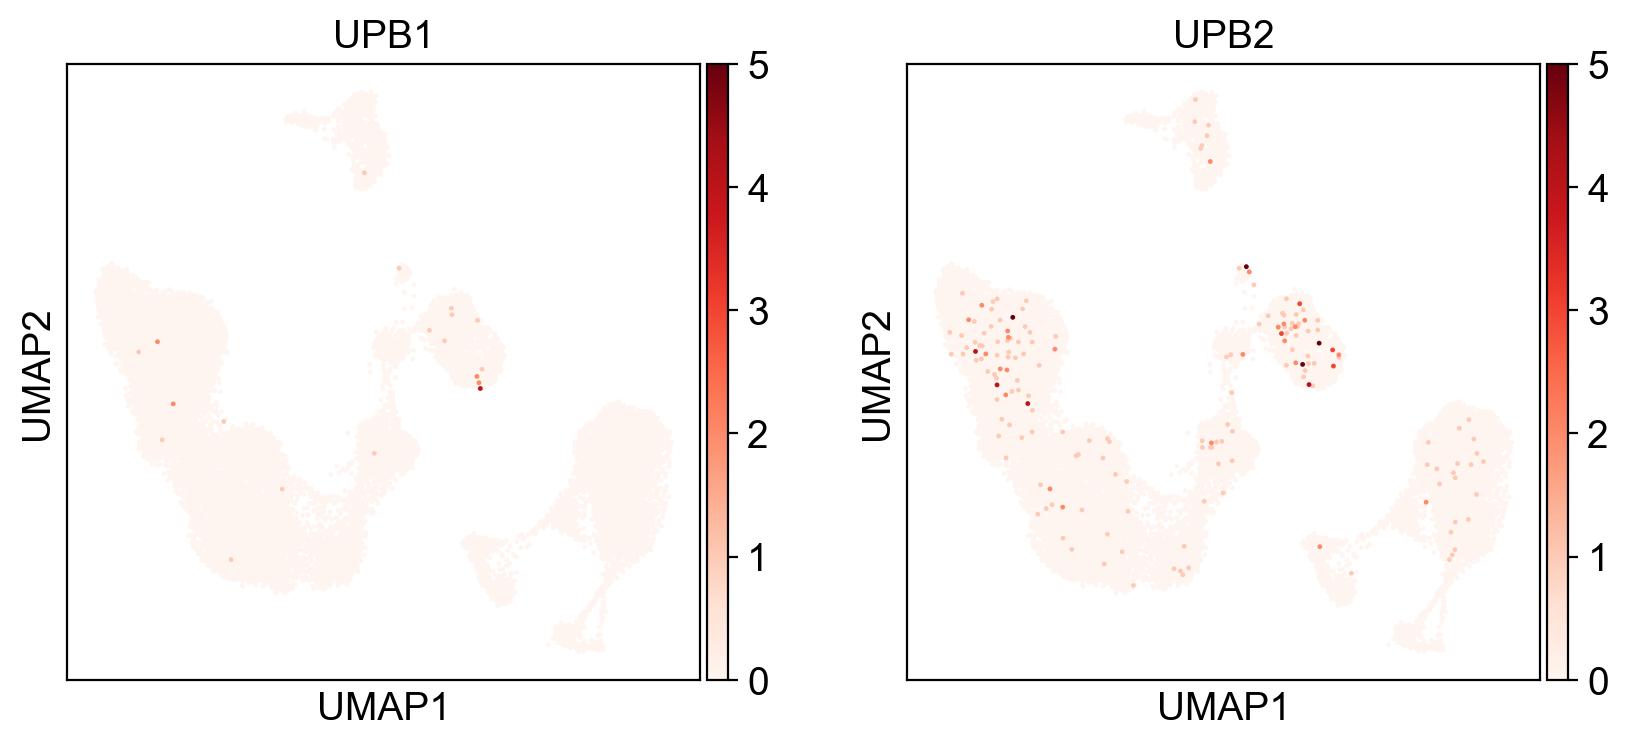

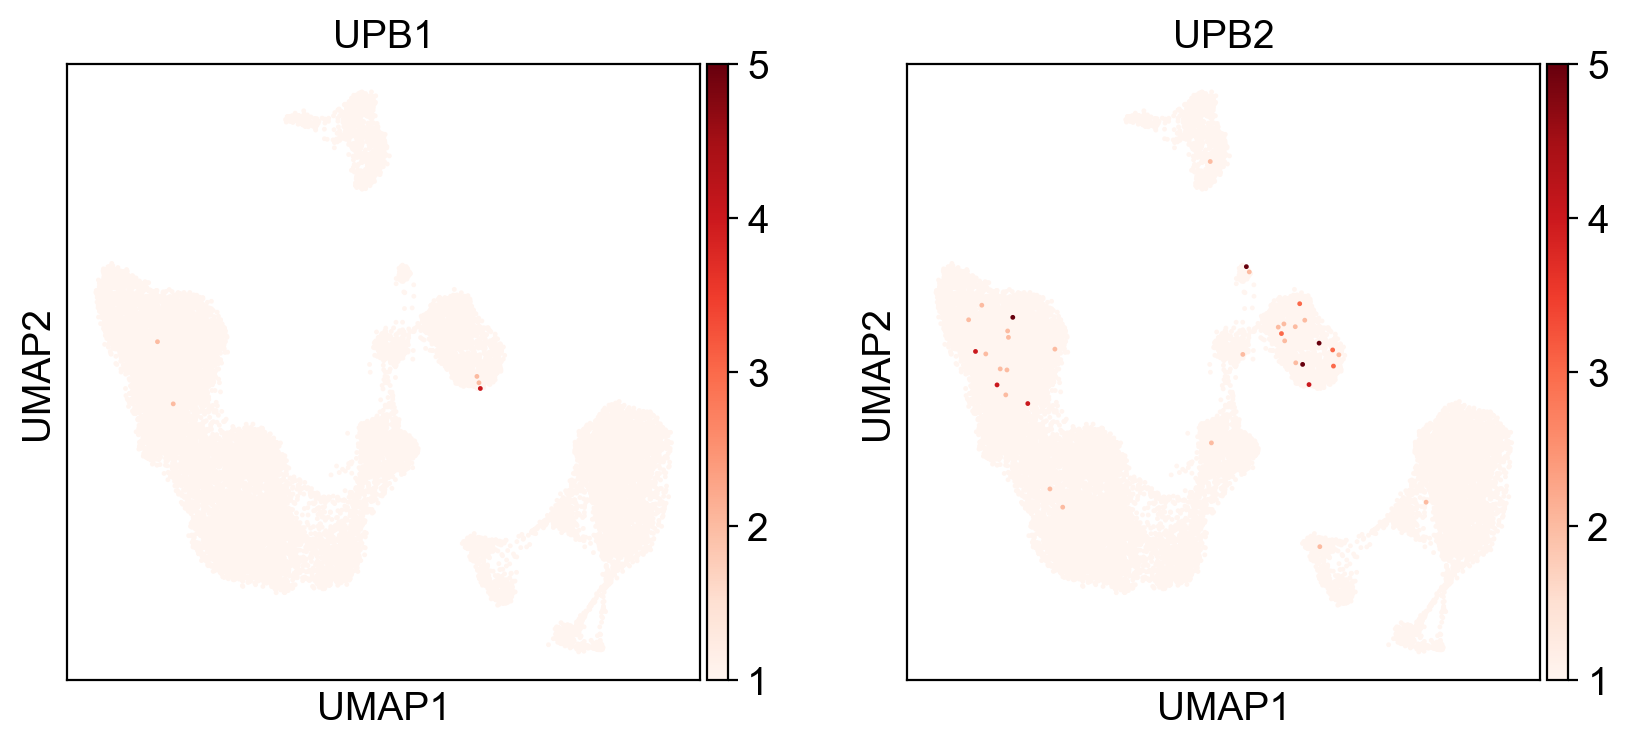

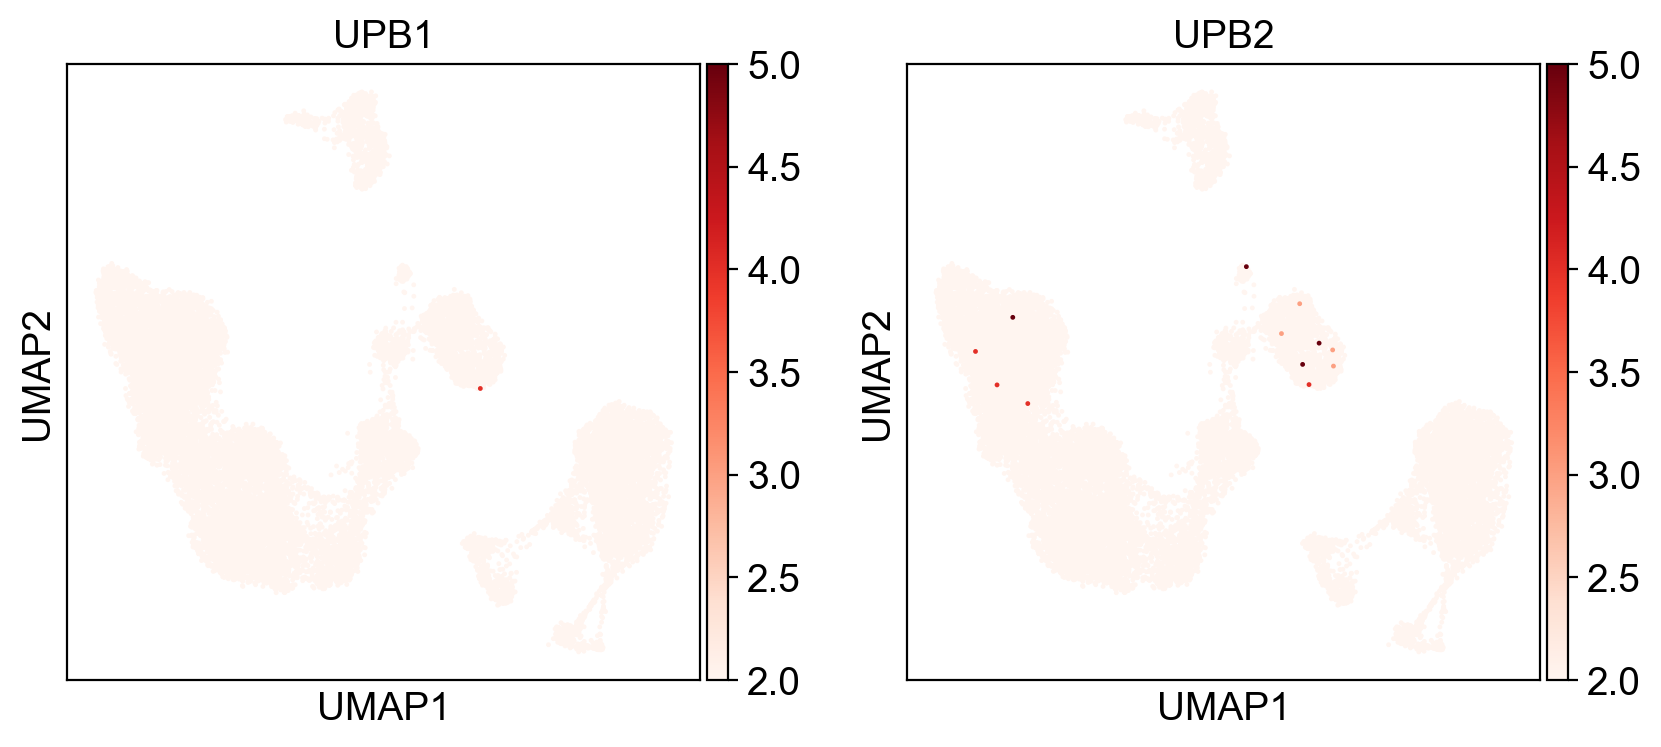

In [21]:
sc.pl.umap(adata, color=["UPB1", "UPB2"], color_map="Reds", vmax=1, size=12)
sc.pl.umap(adata, color=["UPB1", "UPB2"], color_map="Reds", size=12)
sc.pl.umap(adata, color=["UPB1", "UPB2"], color_map="Reds", vmin=0, vmax=5, size=12)
sc.pl.umap(adata, color=["UPB1", "UPB2"], color_map="Reds", vmin=1, vmax=5, size=12)
sc.pl.umap(adata, color=["UPB1", "UPB2"], color_map="Reds", vmin=2, vmax=5, size=12)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


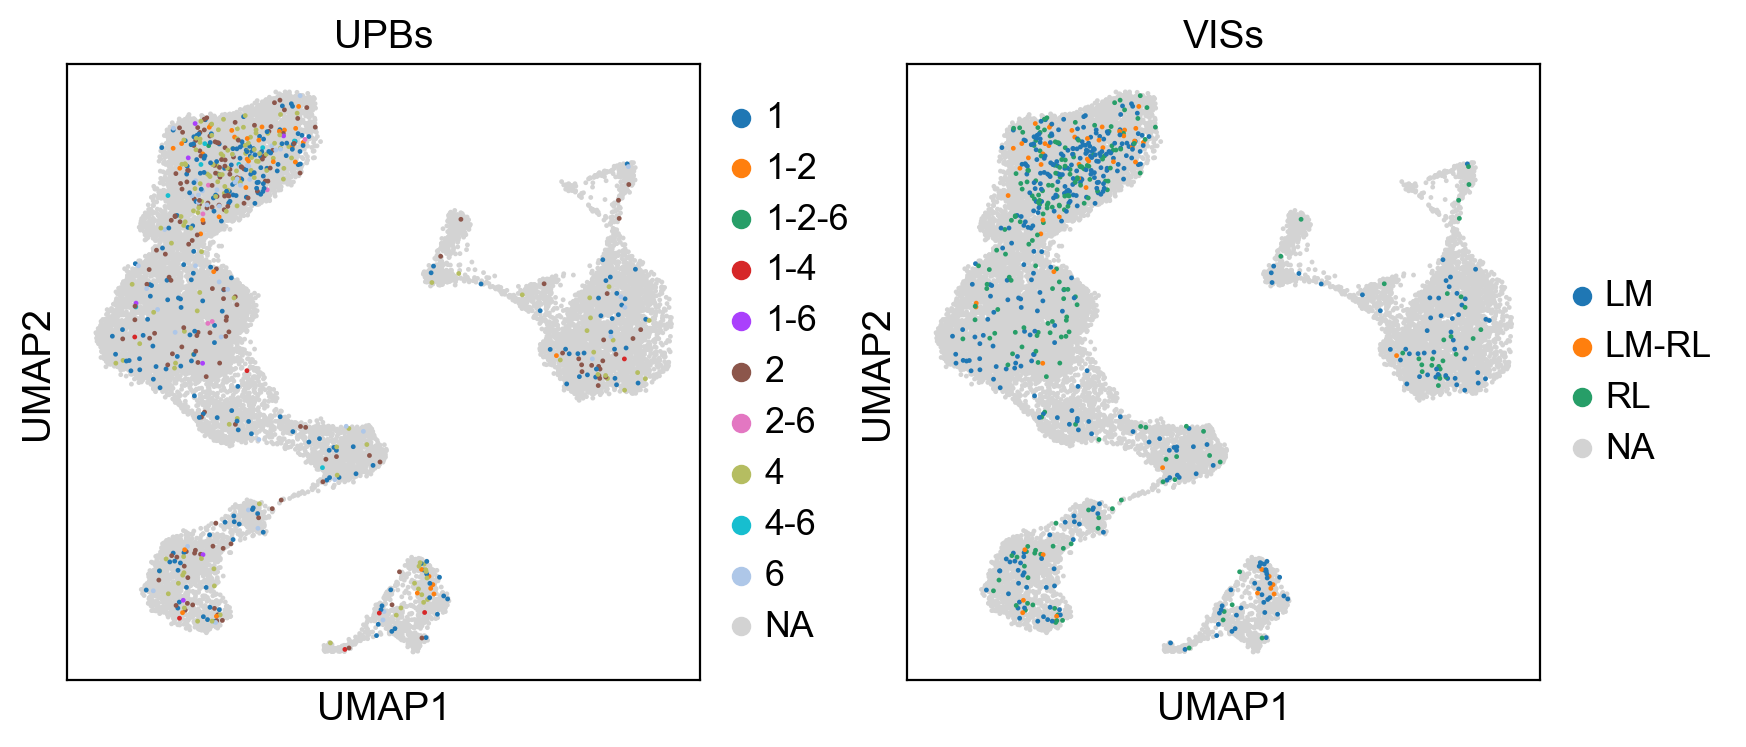

In [49]:
sc.pl.umap(adata, color=["UPBs", "VISs"], size=12)

In [50]:
adata.obs["Doublet"] = adata.obs["Doublet"].astype(str)

In [51]:
adata.write_h5ad("E:/Mouse_V1/Projection_Seq_P28_Glut_Mixed.h5ad")

Read AnnData and Look for Differentially Expressed Genes

In [2]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

adata = sc.read_h5ad("E:/Projection-seq/Projection_Seq_P28_Glut_Mixed.h5ad")

In [3]:
adata.obs["UPBs"] = [None] * adata.shape[0]

upb_combos = ["1", "2", "4", "6", "1-2", "1-4", "1-6", "2-4", "2-6", "4-6", "1-2-4", "1-2-6", "2-4-6"]

for combo in upb_combos:
    cols = ["UPB" + dg for dg in combo.split("-")]
    mask = np.sum(adata.obs[cols] > 1, axis=1) == len(cols)
    adata.obs.loc[mask, "UPBs"] = combo

In [4]:
adata.obs["LM"] = np.sum(adata.obs[["UPB1", "UPB4"]], axis=1) > 1
adata.obs["RL"] = np.sum(adata.obs[["UPB2", "UPB6"]], axis=1) > 1

In [5]:
adata.obs["VISs"] = [None] * adata.shape[0]

vis_combos = ["LM", "RL", "LM-RL"]

for combo in vis_combos:
    cols = combo.split("-")
    mask = np.sum(adata.obs[cols] == True, axis=1) == len(cols)
    adata.obs.loc[mask, "VISs"] = combo

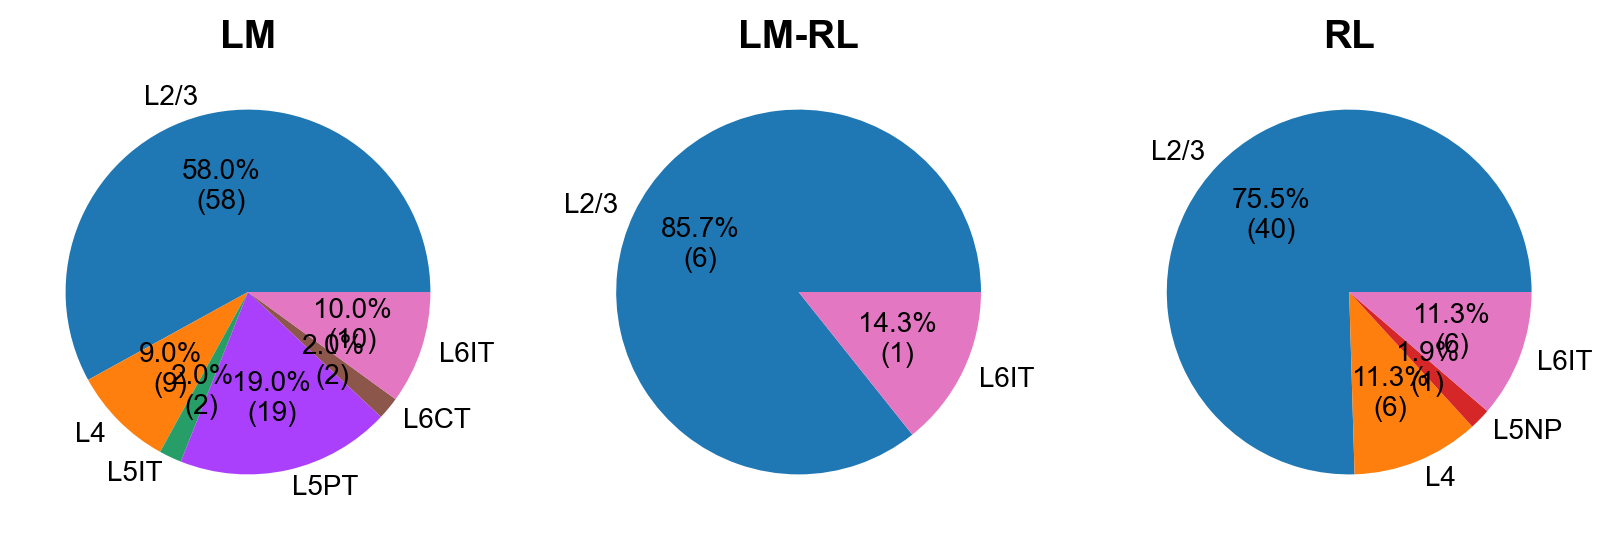

In [8]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

subclasses = np.unique(adata.obs["subclass"])
fig, axs = plt.subplots(1, 3)
for vis, ax in zip(["LM", "LM-RL", "RL"], axs):
    adata_vis = adata[adata.obs["VISs"] == vis, :]
    subclass_count = []
    for subclass in subclasses:
        subclass_count.append(np.sum(adata_vis.obs["subclass"] == subclass))
    subclass_count = np.array(subclass_count)
    colors = np.array(adata.uns["subclass_colors"])
    mask = np.where(subclass_count != 0)[0].astype(int)
    ax.pie(subclass_count[mask], 
           labels=subclasses[mask], 
           colors=colors[mask], 
           autopct=autopct_format(subclass_count[mask]), 
           textprops={"fontsize" : 10})
    ax.grid(False)
    ax.set_title(vis, fontweight="bold")
fig.set_size_inches(10, 3)
plt.show(block=False)

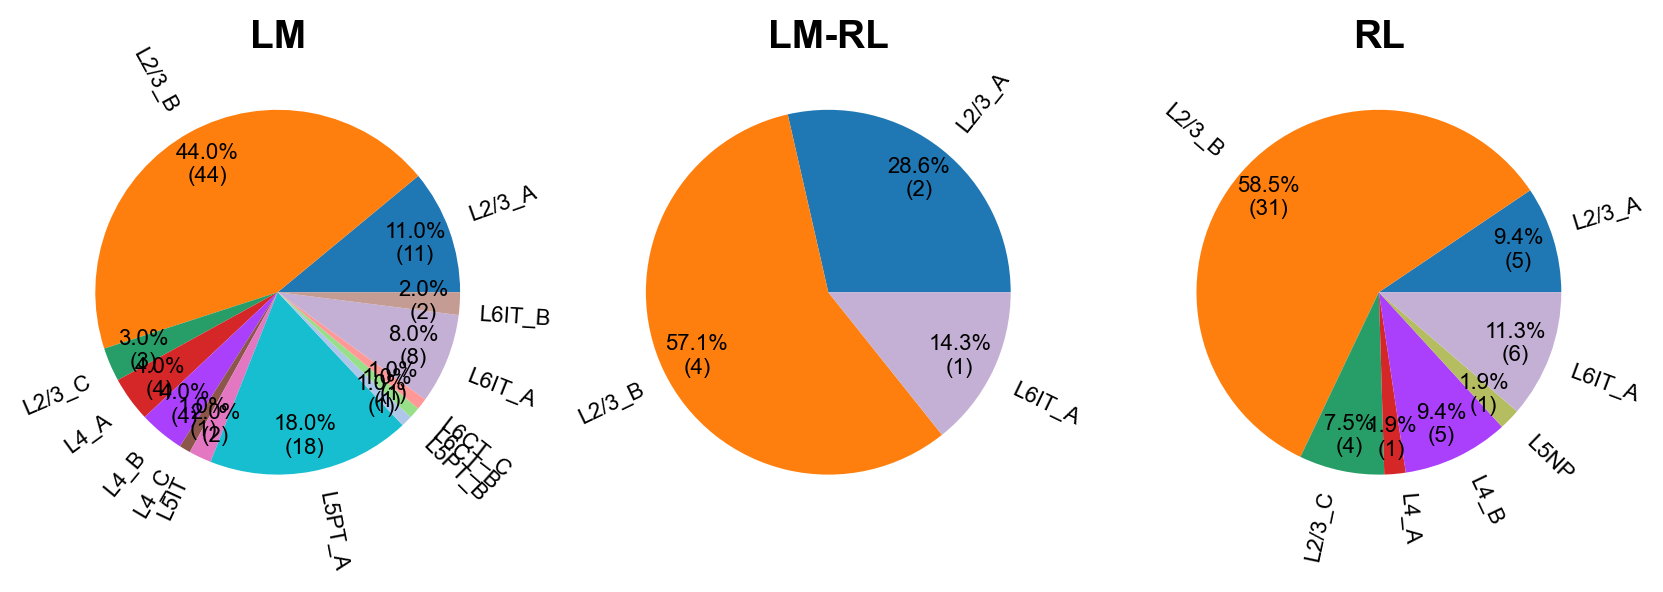

In [9]:
types = np.unique(adata.obs["type"])
fig, axs = plt.subplots(1, 3)
for vis, ax in zip(["LM", "LM-RL", "RL"], axs):
    adata_vis = adata[adata.obs["VISs"] == vis, :]
    type_count = []
    for typ in types:
        type_count.append(np.sum(adata_vis.obs["type"] == typ))
    type_count = np.array(type_count)
    colors = np.array(adata.uns["type_colors"])
    mask = np.where(type_count != 0)[0].astype(int)
    ax.pie(type_count[mask], 
           labels=types[mask], 
           colors=colors[mask], 
           autopct=autopct_format(type_count[mask]), 
           pctdistance=0.8, 
           rotatelabels=True, 
           textprops={"fontsize" : 8})
    ax.grid(False)
    ax.set_title(vis, fontweight="bold")
fig.set_size_inches(10, 3)
plt.show(block=False)

In [12]:
adata_B = adata[adata.obs["type"] == "L2/3_B", :]

In [22]:
adata_B.X = adata_B.raw.X.toarray()
adata_B.uns["log1p"]["base"] = 2
sc.pp.highly_variable_genes(adata_B, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata_B, max_value=10)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


2023-06-26 10:19:09,153 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-26 10:19:10,604 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-26 10:19:10,645 - harmonypy - INFO - Iteration 1 of 20
2023-06-26 10:19:11,948 - harmonypy - INFO - Iteration 2 of 20
2023-06-26 10:19:13,233 - harmonypy - INFO - Iteration 3 of 20
2023-06-26 10:19:14,607 - harmonypy - INFO - Iteration 4 of 20
2023-06-26 10:19:16,038 - harmonypy - INFO - Iteration 5 of 20
2023-06-26 10:19:16,948 - harmonypy - INFO - Iteration 6 of 20
2023-06-26 10:19:17,502 - harmonypy - INFO - Iteration 7 of 20
2023-06-26 10:19:18,168 - harmonypy - INFO - Iteration 8 of 20
2023-06-26 10:19:18,690 - harmonypy - INFO - Iteration 9 of 20
2023-06-26 10:19:19,189 - harmonypy - INFO - Iteration 10 of 20
2023-06-26 10:19:20,082 - harmonypy - INFO - Iteration 11 of 20
2023-06-26 10:19:20,578 - harmonypy - INFO - Converged after 11 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


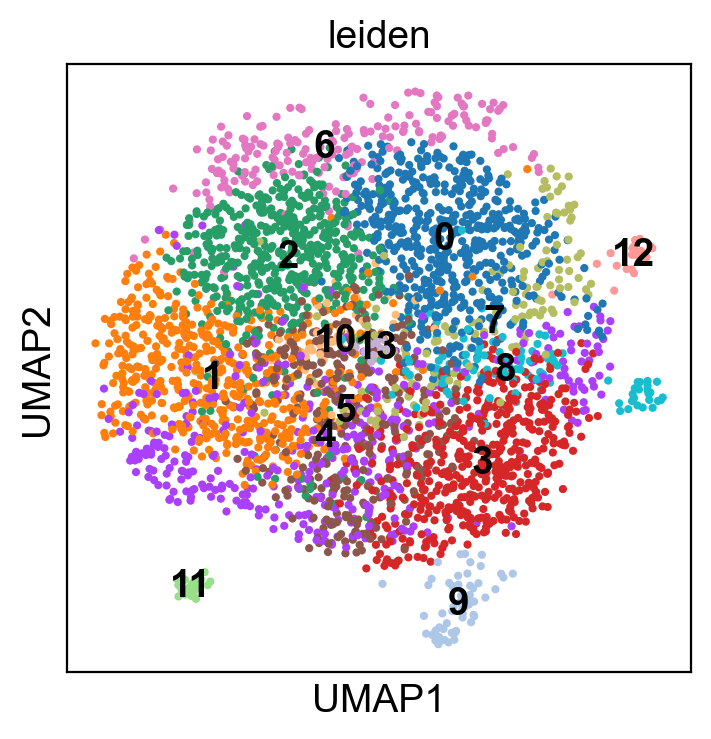

In [29]:
sc.tl.pca(adata_B, svd_solver="arpack")
sce.pp.harmony_integrate(adata_B, "dataset", theta=4, max_iter_harmony=20)
sc.pp.neighbors(adata_B, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata_B, key_added="leiden", resolution=1)
sc.tl.umap(adata_B)
sc.pl.umap(adata_B, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


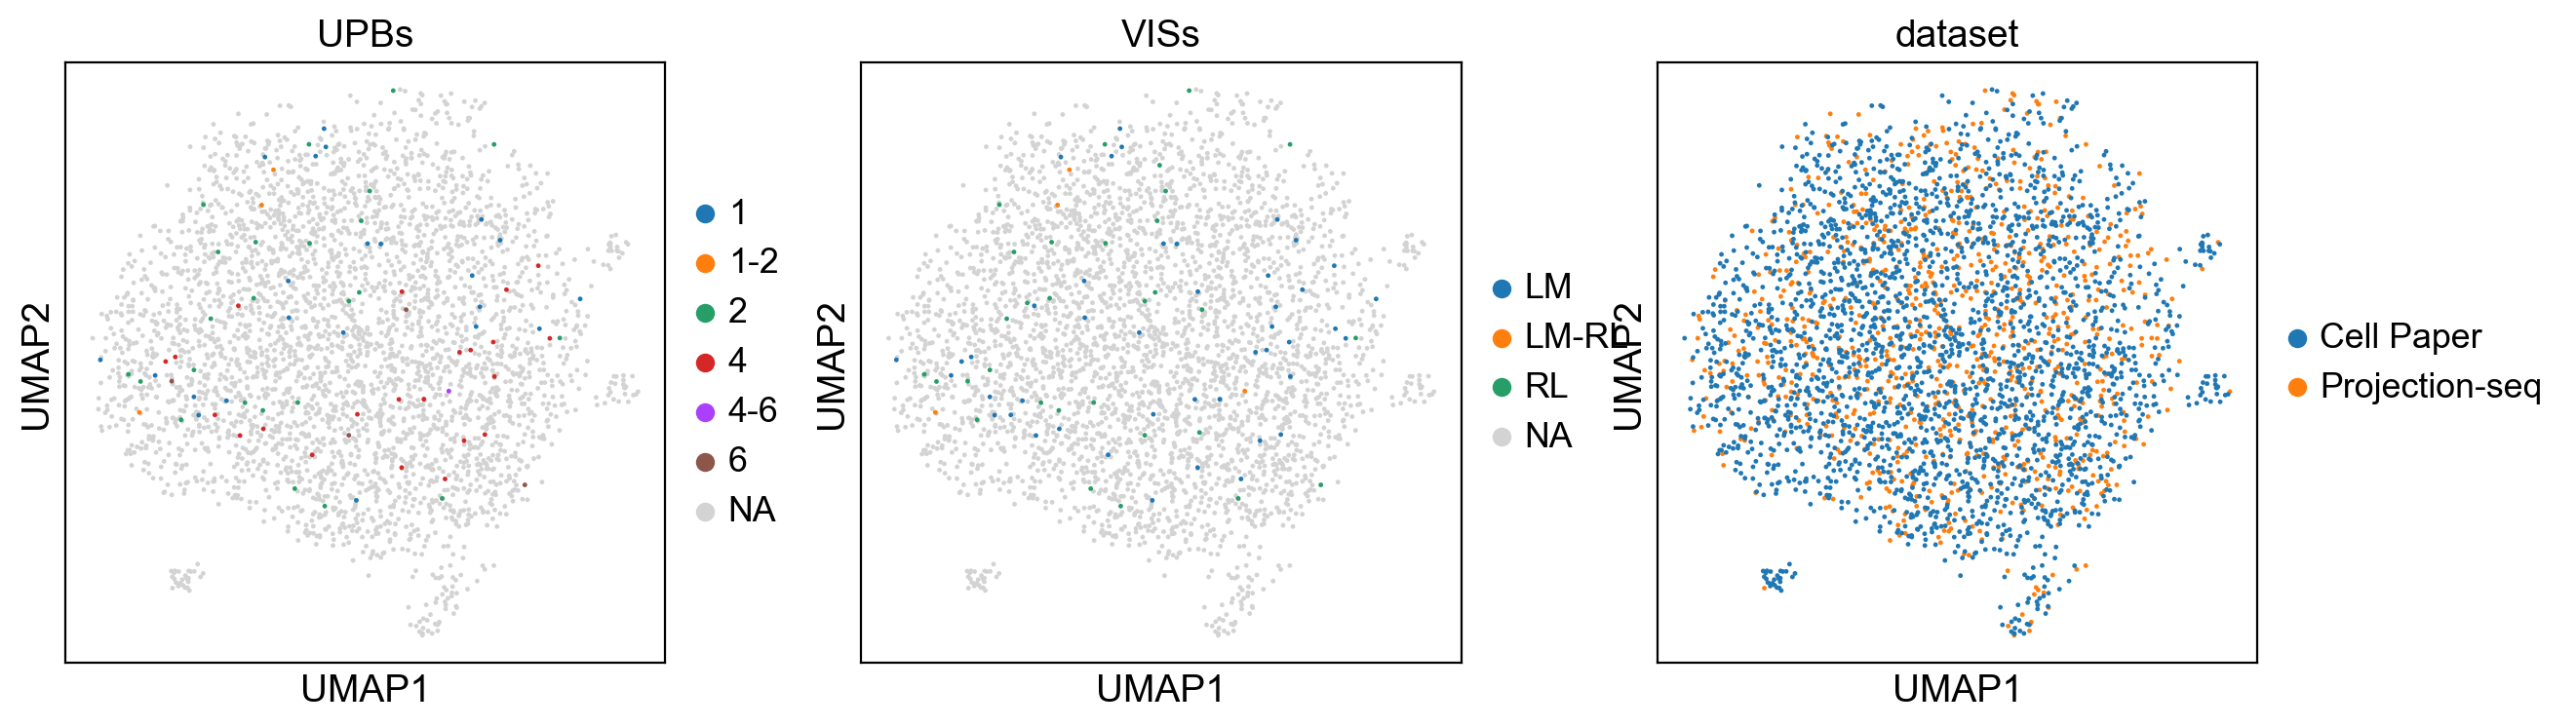

In [30]:
sc.pl.umap(adata_B, color=["UPBs", "VISs", "dataset"], size=12)

In [151]:
VISs = ["LM", "LM-RL", "RL"]
mask = [False] * adata_B.shape[0]
for vis in VISs:
    mask = np.logical_or(mask, adata_B.obs["VISs"] == vis)
adata_UPB = adata_B[mask, :].copy()

In [152]:
adata_UPB

AnnData object with n_obs × n_vars = 79 × 20620
    obs: 'batch', 'doublet', 'doublet_score', 'UPB1', 'UPB2', 'UPB4', 'UPB6', 'LM', 'RL', 'UPBs', 'VISs', 'n_genes', 'percent_mito', 'n_UMIs', 'n_counts', 'leiden', 'class', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'dataset', 'type'
    var: 'feature_types', 'gene_ids-P28_glut', 'n_cells-P28_glut', 'highly_variable-P28_glut', 'means-P28_glut', 'dispersions-P28_glut', 'dispersions_norm-P28_glut', 'mean-P28_glut', 'std-P28_glut', 'gene_ids-Projection_Seq_Glut', 'genome-Projection_Seq_Glut', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Subclass_colors', 'Type_colors', 'VISs_colors', 'dataset_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'subclass_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [174]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

v = np.var(adata_UPB.X, axis=0)

X = adata_UPB.X[:, np.argsort(v)[:-200:-1]]
genes = adata_UPB.var_names[np.argsort(v)[:-200:-1]]
y = np.array(adata_UPB.obs["VISs"])

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

LinearDiscriminantAnalysis()

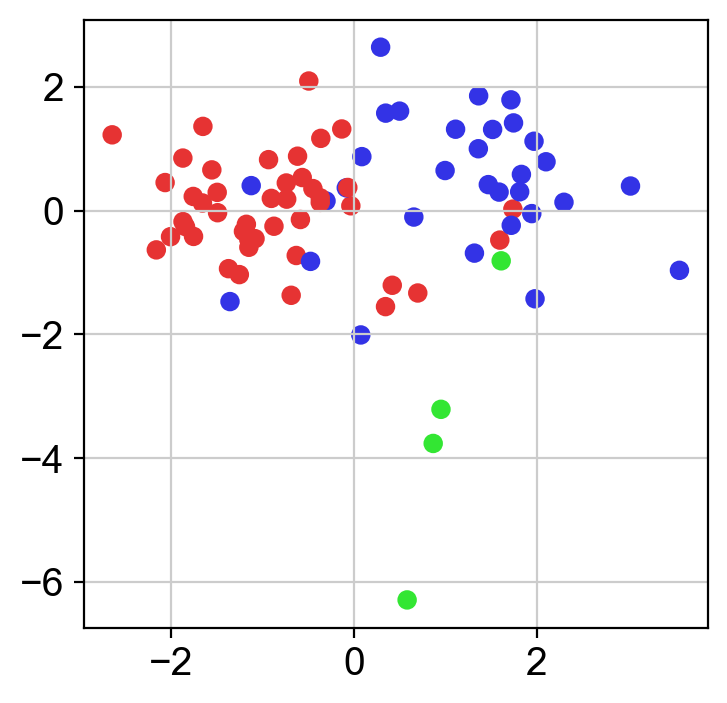

In [175]:
import matplotlib.pyplot as plt

colors = ((0.9, 0.2, 0.2), (0.2, 0.9, 0.2), (0.2, 0.2, 0.9))
color_vec = []
for vis in adata_UPB.obs["VISs"]:
    if vis == "LM":
        color_vec.append(colors[0])
    elif vis == "LM-RL":
        color_vec.append(colors[1])
    elif vis == "RL":
        color_vec.append(colors[2])

dims = clf.transform(X)
fig, ax = plt.subplots()
ax.scatter(dims[:, 0], dims[:, 1], c=color_vec)
plt.show(block=False)

In [178]:
genes_show = genes[np.argsort(clf.scalings_[:, 0])[::-1]]

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


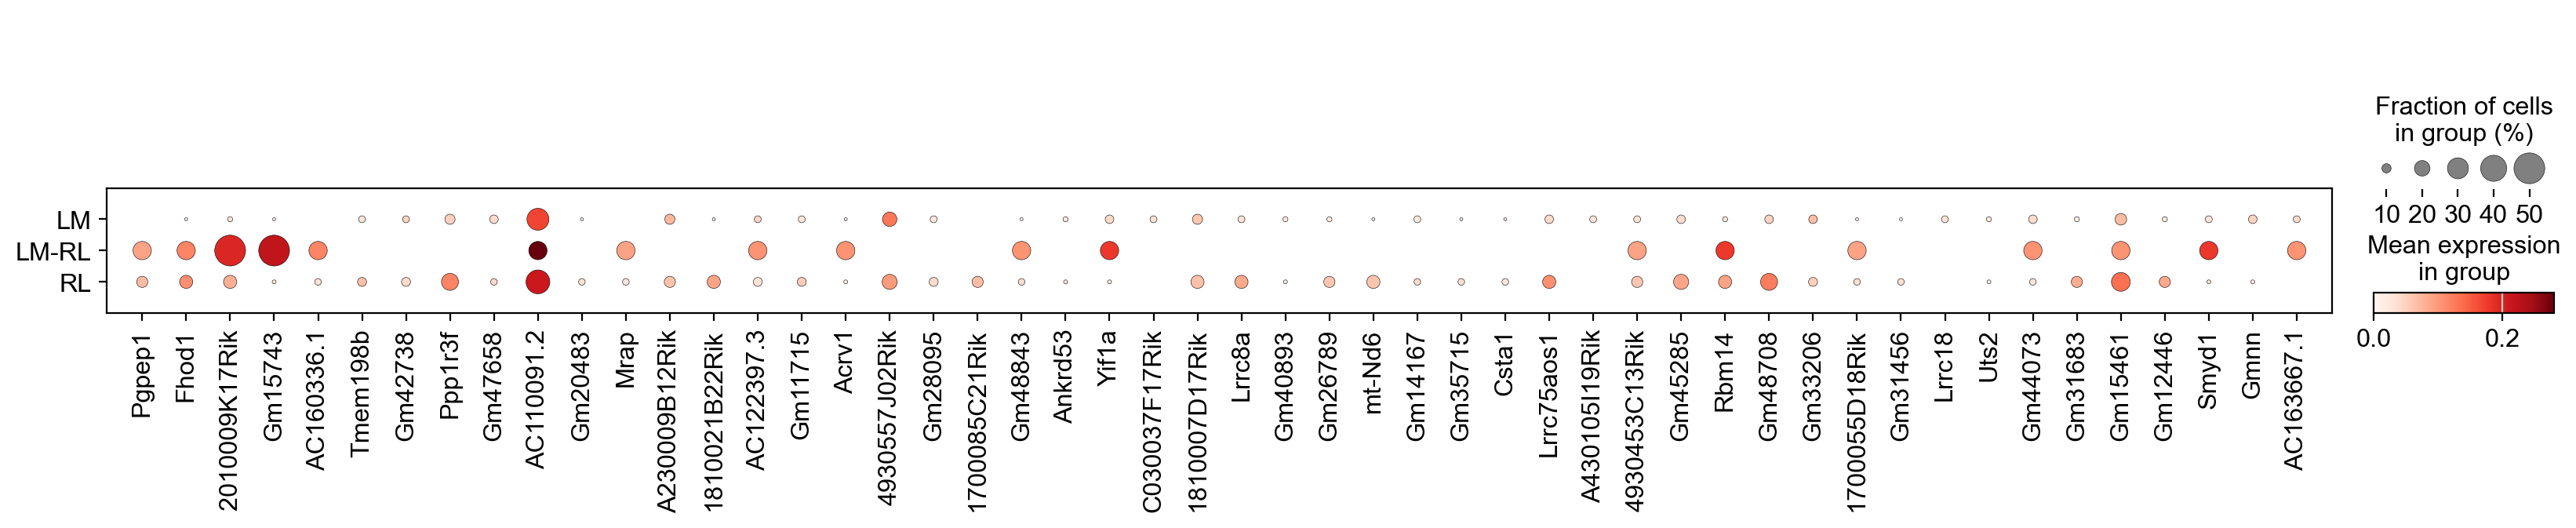

In [179]:
sc.pl.dotplot(adata_UPB, genes_show[:50], groupby="VISs")